In [353]:
from scipy.interpolate import griddata
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, BatchNormalization

In [2]:
import pandas as pd
import numpy as np
import plotly.offline as pyo
from plotly import subplots
import plotly.graph_objects as go

In [172]:
client = pd.read_csv("../../data/client.csv")
ePrices = pd.read_csv("../../data/electricity_prices.csv")
gasPrices = pd.read_csv("../../data/gas_prices.csv")
train = pd.read_csv("../../data/train.csv")

In [196]:
weatherPredInt = pd.read_csv("interpolPredWeather.csv")
weatherHistInt = pd.read_csv("../histWeatherSnowCover.csv")

# process data

### merge client & train, add business feat & interpolate daylight savings

In [174]:
producing = train.loc[train.is_consumption == 0]
consuming = train.loc[train.is_consumption == 1]
train = pd.merge(producing.drop('is_consumption',axis = 1), consuming.drop('is_consumption',axis = 1),on=['data_block_id','prediction_unit_id','datetime','county','is_business','product_type'], how='outer',suffixes=('_prod', '_cons'))
del producing, consuming
print(train.shape)

clientsTime = pd.merge(train, client, on=['county','is_business','product_type','data_block_id'], how='inner')

clientsTime['datetime'] = pd.to_datetime(clientsTime['datetime'])
clientsTime['yearday'] = clientsTime['datetime'].dt.day_of_year
clientsTime['weekday'] = clientsTime['datetime'].dt.day_of_week
clientsTime['month'] = clientsTime['datetime'].dt.month
clientsTime['monthday'] = clientsTime['datetime'].dt.day

unique_pairs = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs)}
clientsTime['business_prodType'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'])))

unique_pairs_cust = list(set(zip(clientsTime['is_business'], clientsTime[ 'product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))
pair_index_dict = {pair: index for index, pair in enumerate(unique_pairs_cust)}
clientsTime['ind_customer_id'] = list(map(pair_index_dict.get, zip(clientsTime['is_business'], clientsTime['product_type'], clientsTime['county'], clientsTime['eic_count'],clientsTime['installed_capacity'])))

# interpolate daylight savings
clientsTime = clientsTime.interpolate()

(1009176, 10)


/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_25586/1731394031.py:24: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



### prepare electric prices

In [197]:
ePrices['forecast_date'] = pd.to_datetime(ePrices['forecast_date'])

# Set 'timestamp' as the index
ePrices.set_index('forecast_date', inplace=True)

# Resample to fill missing hours
df_resampled = ePrices.resample('1H').asfreq()

# Linearly interpolate missing values
ePrices = df_resampled.interpolate(method='linear')

/var/folders/15/v1vyry112dv3d398dy47k8v40000gn/T/ipykernel_25586/2052008978.py:10: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.



# write data into python arrays

In [200]:
#clientsTime, weatherPredInt, weatherHistInt, ePrices, gasPrices

featPredWeather = [
        #'latitude', 'longitude', 
        'County', #'forecast_datetime',
       'hours_ahead',
        'data_block_id', #'origin_datetime', 
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       #'sunrise', 'sunset',
       #'daylight', 'minDaylight'
       ]

predWeatherComplete = weatherPredInt[featPredWeather]
del weatherPredInt

featHistWeather = [
       #'latitude', 'longitude', 
       'County',
       #'datetime', 
       'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
histWeatherComplete = weatherHistInt[featHistWeather]
del weatherHistInt

# can't use client id as an axis in data because it's not constant!
y = np.zeros((clientsTime.shape[0],2))
y_indexes = np.zeros((clientsTime.shape[0],2)) # dataframe indexes in the end, not important for now
index_y = 0

customers = []

constValsArray = np.zeros((1,14))
targetsArray = np.zeros((1,24,2))
ePricesArray = np.zeros((1,24,1))

nFeatHistWeather = histWeatherComplete.shape[1]-1
histWeatherArray = np.zeros((1,24,nFeatHistWeather))
nFeatPredWeather = predWeatherComplete.shape[1]-1
predWeatherArray = np.zeros((1,24,nFeatPredWeather))
dataBlockIdArray = np.zeros((1))

# loop over customer, append all data cycles for each customer
for customerId in clientsTime.ind_customer_id.unique():
    customerSlice = clientsTime.loc[clientsTime.ind_customer_id == customerId]

    for dataBlockId in customerSlice.data_block_id.unique():
        timeSlice = customerSlice.loc[customerSlice.data_block_id == dataBlockId]
        gasSlice = gasPrices.loc[gasPrices.data_block_id == dataBlockId]
        eSlice   = ePrices.loc[ePrices.data_block_id == dataBlockId]

        if len(timeSlice.yearday.unique()) > 1:
            print(timeSlice.yearday.unique())

        # const values
        yearday = timeSlice.yearday.unique()[0]
        weekday = timeSlice.weekday.unique()[0]
        month   = timeSlice.month.unique()[0]
        monthday = timeSlice.monthday.unique()[0]

        county       = customerSlice.county.unique()[0]
        is_business  = customerSlice.is_business.unique()[0]
        product_type = customerSlice.product_type.unique()[0]
        prediction_unit_id = customerSlice.prediction_unit_id.unique()[0] #should be redundant
        eic_count          = customerSlice.eic_count.unique()[0]
        installed_capacity = customerSlice.installed_capacity.unique()[0]
    
        business_prodType = customerSlice.business_prodType.unique()[0]
        ind_customer_id   = customerSlice.ind_customer_id.unique()[0]

        

        lowest_price_per_mwh = gasSlice.lowest_price_per_mwh.iloc[0]
        highest_price_per_mwh = gasSlice.highest_price_per_mwh.iloc[0]
        euros_per_mwh = eSlice['euros_per_mwh'].to_numpy()
        if euros_per_mwh.shape[0] == 23:
            print(dataBlockId, customerId)

        y_cons = timeSlice['target_cons'] / installed_capacity
        y_prod = timeSlice['target_prod'] / installed_capacity

        histWeather = histWeatherComplete.loc[(histWeatherComplete.data_block_id == dataBlockId) & (histWeatherComplete.County == county)]
        predWeather = predWeatherComplete.loc[(predWeatherComplete.data_block_id == dataBlockId) & (predWeatherComplete.County == county)]

        histWeather = histWeather.drop('data_block_id', axis = 1)
        predWeather = predWeather.drop('data_block_id', axis = 1)


        if y_cons.shape[0] == 23:
            print(dataBlockId, customerId)

        new_row = np.array([county, is_business, product_type, prediction_unit_id, eic_count, installed_capacity, 
        business_prodType,ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh,
        yearday,weekday,month,monthday
        ])
        constValsArray = np.vstack((constValsArray, new_row))

        new_row = np.zeros((1,24,2))
        new_row[:,:,0] = y_cons
        new_row[:,:,1] = y_prod
        targetsArray = np.concatenate((targetsArray, new_row), axis=0)

        new_row = np.zeros((1,24,1))
        new_row[0,:,0] = euros_per_mwh
        ePricesArray = np.concatenate((ePricesArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatHistWeather)) #without datablock id
        new_row[:,:,:] = histWeather
        histWeatherArray = np.concatenate((histWeatherArray, new_row), axis=0)

        new_row = np.zeros((1,24,nFeatPredWeather)) # withotu datablock id
        new_row[:,:,:] = predWeather
        predWeatherArray = np.concatenate((predWeatherArray, new_row), axis=0)

        dataBlockIdArray = np.concatenate((dataBlockIdArray, np.array([dataBlockId])))
    


In [201]:
#remove first rows
targetsArray     = targetsArray[1:,:,:]
constValsArray   = constValsArray[1:,:]
ePricesArray     = ePricesArray[1:,:,:]
histWeatherArray = histWeatherArray[1:,:,:]
predWeatherArray = predWeatherArray[1:,:,:]
dataBlockIdArray = dataBlockIdArray[1:]
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41869, 24, 2) (41869, 14) (41869, 24, 1) (41869, 24, 18) (41869, 24, 14) (41869,)


In [202]:
#calc absolute targets, not normalized by capacity
targetsAbs = targetsArray.copy()
targetsAbs = targetsAbs * constValsArray[:,5].reshape(constValsArray.shape[0],1,1)
print(targetsAbs.shape)

(41869, 24, 2)


In [203]:
print(targetsArray.shape, constValsArray.shape, ePricesArray.shape,histWeatherArray.shape, predWeatherArray.shape, dataBlockIdArray.shape)

(41869, 24, 2) (41869, 14) (41869, 24, 1) (41869, 24, 18) (41869, 24, 14) (41869,)


In [204]:
np.savez('data_arrays_snowcover_GasPr_noSunrise_timeFeat.npz', arr1=targetsArray, arr2=constValsArray, arr3=ePricesArray, arr4 = histWeatherArray, arr5=predWeatherArray, arr6=dataBlockIdArray, arr7=targetsAbs)

# load data

In [445]:
loaded_data = np.load('data_arrays_snowcover_GasPr_noSunrise_timeFeat.npz')

# Access individual arrays by their keys
targetsArray = loaded_data['arr1']
constValsArray = loaded_data['arr2']
ePricesArray = loaded_data['arr3']
histWeatherArray = loaded_data['arr4']
predWeatherArray = loaded_data['arr5']
dataBlockIdArray = loaded_data['arr6']
targetsAbs = loaded_data['arr7']

featConst =['county', 'is_business', 'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity', 'business_prodType', 'ind_customer_id',
'lowest_price_per_mwh','highest_price_per_mwh','yearday','weekday','month','monthday'
]

featPredWeather = [
        'County',
       'hours_ahead',
       # 'data_block_id',
       'temperatureint',
       'dewpointint', 'cloudcover_highint', 'cloudcover_lowint',
       'cloudcover_midint', 
       'cloudcover_totalint',
       '10_metre_u_wind_componentint', '10_metre_v_wind_componentint',
       'direct_solar_radiationint', 'surface_solar_radiation_downwardsint',
       'snowfallint', 'total_precipitationint', 
       ]
featPredWeatherKeepIdx = [0,1,2,3,4,5,6,10,11,12,13]
featPredWeatherKeepIdx = [1,2,3,13]
predWeatherArray=predWeatherArray[:,:,featPredWeatherKeepIdx]
featPredWeather = [featPredWeather[i] for i in featPredWeatherKeepIdx]

#correct hours
predWeatherArray[:,:,1] = predWeatherArray[:,:,1] - 24

# add sin of hours
sinDay = np.reshape(np.sin((predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, sinDay), axis=2)
featPredWeatherKeepIdx = featPredWeatherKeepIdx + [len(featPredWeatherKeepIdx)] 
featPredWeather = featPredWeather + ['sinDay']

cosDay = np.reshape(np.cos((predWeatherArray[:,:,1] - 24)*np.pi/24),(predWeatherArray.shape[0],predWeatherArray.shape[1],1))
predWeatherArray = np.concatenate((predWeatherArray, cosDay), axis=2)
featPredWeatherKeepIdx = featPredWeatherKeepIdx + [len(featPredWeatherKeepIdx)] 
featPredWeather = featPredWeather + ['cosDay']
nPredFeat = predWeatherArray.shape[2]


# add sin of year day
sinYear = np.reshape(np.sin(2*constValsArray[:,10]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, sinYear), axis=1)
featConst = featConst + ['sinYearDay']

cosYear = np.reshape(np.cos(2*constValsArray[:,10]*np.pi/365),(constValsArray.shape[0],1))
constValsArray = np.concatenate((constValsArray, cosYear), axis=1)
featConst = featConst + ['cosYearDay']
nConst = constValsArray.shape[1]



featHistWeather = [
       'County', 
       #'data_block_id', 
       'temperatureint', 'dewpointint', 'rainint',
       'snowfallint', 'surface_pressureint', 'cloudcover_totalint',
       'cloudcover_lowint', 'cloudcover_midint', 'cloudcover_highint',
       'windspeed_10mint', 'winddirection_10mint', 'shortwave_radiationint',
       'direct_solar_radiationint', 'diffuse_radiationint', 'meltingInCM',
       'snowHeightFlux', 'snowcover'
]
featHistWeatherKeepIdx = [1,10]
histWeatherArray=histWeatherArray[:,:,featHistWeatherKeepIdx]

featHistWeather = [featHistWeather[i] for i in featHistWeatherKeepIdx]
nHistFeat = histWeatherArray.shape[2]

print(nPredFeat,nHistFeat,nConst)

6 2 16


In [388]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (4, 33495) + inhomogeneous part.

# build a model & train it

In [389]:
tf.random.set_seed(42)
from sklearn.model_selection import train_test_split

### shuffle if needed & split into x train y train

In [446]:
np.random.seed(42)
index_array = np.arange(targetsArray.shape[0])
np.random.shuffle(index_array)
arrays = [constValsArray,ePricesArray,histWeatherArray,predWeatherArray,targetsAbs,targetsArray,dataBlockIdArray]
shuffledArr = [arr[index_array] for arr in arrays]
del arrays

In [447]:
trainSplit = int(shuffledArr[4].shape[0]*0.8)
X_train = [shuffledArr[0][0:trainSplit,:],shuffledArr[1][0:trainSplit,:,:],shuffledArr[2][0:trainSplit,:,:],shuffledArr[3][0:trainSplit,:,:]]
# only const and e prices
X_train = [shuffledArr[0][0:trainSplit,:],shuffledArr[1][0:trainSplit,:,:]]
y_trainAbs = shuffledArr[4][0:trainSplit,:]
y_train = shuffledArr[5][0:trainSplit,:]

X_test = [shuffledArr[0][trainSplit:-1,:],shuffledArr[1][trainSplit:-1,:,:]]
y_testAbs = shuffledArr[4][trainSplit:-1,:]
y_test = shuffledArr[5][trainSplit:-1,:]

In [428]:
y_trainAbs.shape

(33495, 24, 2)

#### use standard scaler for target

In [432]:
# normalize the target
from sklearn.preprocessing import StandardScaler

scalerT = StandardScaler()
y_trainAbsN_cons = scalerT.fit_transform(y_trainAbs[:,:,0].reshape(-1, 1)).reshape(-1,24,1)
y_testAbsN_cons  = scalerT.transform(y_testAbs[:,:,0].reshape(-1, 1)).reshape(-1,24,1)

### split unshuffled data

In [ ]:
trainSplit = int(targetsArray.shape[0]*0.3)
X_train = [constValsArray[0:trainSplit,:],ePricesArray[0:trainSplit,:,:],histWeatherArray[0:trainSplit,:,:],predWeatherArray[0:trainSplit,:,:]]
y_train = targetsArray[0:trainSplit,:]
y_trainAbs = targetsAbs[0:trainSplit,:]

X_test = [constValsArray[trainSplit:-1,:],ePricesArray[trainSplit:-1,:,:],histWeatherArray[trainSplit:-1,:,:],predWeatherArray[trainSplit:-1,:,:]]
y_test = targetsArray[trainSplit:-1,:]
y_testAbs = targetsAbs[trainSplit:-1,:]

### define model & train it

#### model with 2 outputs

In [ ]:
# Define the inputs
weatherPred_inputs = tf.keras.Input(shape=(24, 16), name='weatherPred_inputs')
ePrices_inputs = tf.keras.Input(shape=(24, 1), name='ePrices_inputs')

weatherHist_input = tf.keras.Input(shape=(24, 18), name='weatherHist_input')
constant_inputs = tf.keras.Input(shape=(14,), name='constant_inputs')

# Process the time-based inputs
weatherPred_flattened = layers.Flatten()(weatherPred_inputs)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
weatherPred_flattened = layers.Dense(408, activation='relu')(weatherPred_flattened)
#weatherPred_flattened = layers.Dense(256, activation='relu')(weatherPred_flattened)
#weatherPred_flattened = layers.Dense(64, activation='relu')(weatherPred_flattened)

weatherHist_flattened = layers.Flatten()(weatherHist_input)
weatherHist_flattened = layers.Dense(240, activation='relu')(weatherHist_flattened)
weatherHist_flattened = layers.Dense(240, activation='relu')(weatherHist_flattened)
weatherHist_flattened = layers.Dense(240, activation='relu')(weatherHist_flattened)
#weatherHist_flattened = layers.Dense(64, activation='relu')(weatherHist_flattened)

ePrices_layer = layers.Flatten()(ePrices_inputs)
ePrices_layer = layers.Dense(24, activation='relu')(ePrices_layer)

# Concatenate all inputs
x = layers.Concatenate()([weatherPred_flattened, weatherHist_flattened, ePrices_layer, constant_inputs])

# Main dense block
for i in range(0,5):
    x = layers.Dense(540, activation='relu')(x)
    #x = layers.Dropout(0.1)(x)

# Output layer for 24*2 targets
output_layer = layers.Dense(24 * 2, activation='linear', name='output')(x)
output_layer = layers.Reshape((24, 2))(output_layer)

In [ ]:
model = models.Model(inputs=[constant_inputs,ePrices_inputs, weatherHist_input, weatherPred_inputs], outputs=output_layer)

# Compile the model with an appropriate loss function and optimizer
model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=200) #batch size = 110 weather station

In [ ]:
fig = go.Figure()
length = len(history.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [ ]:
a = model.predict(X_test)
predVals = a*X_test[0][:,5].reshape(X_test[0].shape[0],1,1)
print(np.mean(np.abs(y_testAbs - predVals)))
a = model.predict(X_train)
predVals = a*X_train[0][:,5].reshape(X_train[0].shape[0],1,1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs - predVals)))
del a,predVals,trueVals

### use a model for production and consumption separately

In [14]:
# production
# Define the inputs
weatherPred_inputs1 = tf.keras.Input(shape=(24, 10), name='weatherPred_inputs1')
ePrices_inputs1 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs1')

weatherHist_input1 = tf.keras.Input(shape=(24, 5), name='weatherHist_input1')
constant_inputs1 = tf.keras.Input(shape=(14,), name='constant_inputs1')

# Process the time-based inputs
weatherPred_flattened1 = layers.Flatten()(weatherPred_inputs1)
for i in range(0,3):
    weatherPred_flattened1 = layers.Dense(240, activation='relu')(weatherPred_flattened1)

weatherHist_flattened1 = layers.Flatten()(weatherHist_input1)
for i in range(0,3):
    weatherHist_flattened1 = layers.Dense(120, activation='relu')(weatherHist_flattened1)

ePrices_layer1 = layers.Flatten()(ePrices_inputs1)
ePrices_layer1 = layers.Dense(24, activation='relu')(ePrices_layer1)

# Concatenate all inputs
x1 = layers.Concatenate()([weatherPred_flattened1, weatherHist_flattened1, ePrices_layer1, constant_inputs1])

# Main dense block
for i in range(0,5):
    x1 = layers.Dense(540, activation='relu')(x1)
    #x = layers.Dropout(0.1)(x)

# Output layer for 24*2 targets
output_layer1 = layers.Dense(24 * 1, activation='linear', name='output1')(x1)
output_layer1 = layers.Reshape((24, 1))(output_layer1)

model2 = models.Model(inputs=[constant_inputs1,ePrices_inputs1, weatherHist_input1, weatherPred_inputs1], outputs=output_layer1)

# Compile the model with an appropriate loss function and optimizer
model2.compile(optimizer='adam', loss='mae')#, metrics=['mae'])
# 0 = cons, 1 = prod
history2 = model2.fit(X_train, y_trainAbs[:,:,1], validation_data=(X_test, y_testAbs[:,:,1]), epochs=100, batch_size=400) #batch size = 110 weather station

2023-12-27 16:47:15.300619: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
84/84 [==============================] - 5s 51ms/step - loss: 46.4742 - val_loss: 33.8714
Epoch 2/100
84/84 [==============================] - 4s 50ms/step - loss: 33.7909 - val_loss: 29.8004
Epoch 3/100
84/84 [==============================] - 4s 52ms/step - loss: 32.9166 - val_loss: 30.5366
Epoch 4/100
84/84 [==============================] - 5s 55ms/step - loss: 30.3373 - val_loss: 31.4892
Epoch 5/100
84/84 [==============================] - 4s 54ms/step - loss: 30.5417 - val_loss: 28.8298
Epoch 6/100
84/84 [==============================] - 5s 54ms/step - loss: 28.7493 - val_loss: 27.5593
Epoch 7/100
84/84 [==============================] - 4s 53ms/step - loss: 27.7565 - val_loss: 27.9405
Epoch 8/100
84/84 [==============================] - 5s 56ms/step - loss: 27.9888 - val_loss: 28.5697
Epoch 9/100
84/84 [==============================] - 4s 52ms/step - loss: 27.5353 - val_loss: 30.4658
Epoch 10/100
84/84 [==============================] - 4s 52ms/step - loss: 27.2149

In [433]:
#consumption

#weatherPred_inputs2 = tf.keras.Input(shape=(24, 6), name='weatherPred_inputs2')
ePrices_inputs2 = tf.keras.Input(shape=(24, 1), name='ePrices_inputs2')
#weatherHist_input2 = tf.keras.Input(shape=(24, 2), name='weatherHist_input2')
constant_inputs2 = tf.keras.Input(shape=(16,), name='constant_inputs2')

#eatherPred_inputs2_normalized = BatchNormalization()(weatherPred_inputs2)
ePrices_inputs2_normalized = BatchNormalization()(ePrices_inputs2)
#weatherHist_input2_normalized = BatchNormalization()(weatherHist_input2)
constant_inputs2_normalized = BatchNormalization()(constant_inputs2)


#weatherPred_flattened2 = layers.Flatten()(weatherPred_inputs2_normalized)
#for i in range(0,3):
#    weatherPred_flattened2 = layers.Dense(144, activation='relu')(weatherPred_flattened2)
#
#weatherHist_flattened2 = layers.Flatten()(weatherHist_input2_normalized)
#for i in range(0,3):
#    weatherHist_flattened2 = layers.Dense(48, activation='relu')(weatherHist_flattened2)

ePrices_layer2 = layers.Flatten()(ePrices_inputs2_normalized)
for i in range(0,1):
    ePrices_layer2 = layers.Dense(24, activation='relu')(ePrices_layer2)

constInp_layer2 = layers.Dense(16, activation='relu')(constant_inputs2_normalized)
for i in range(0,0):
    constInp_layer2 = layers.Dense(16, activation='relu')(constInp_layer2)

# Concatenate all inputs
#x2 = layers.Concatenate()([weatherPred_flattened2, weatherHist_flattened2, ePrices_layer2, constInp_layer2])
x2 = layers.Concatenate()([ePrices_layer2, constInp_layer2])

# Main dense block
for i in range(0,6):
    x2 = layers.Dense(260, activation='relu')(x2) #making it bigger helps a bit, but not super significant
    #x = layers.Dropout(0.1)(x)

#x2 = layers.Dense(256, activation='relu')(x2)
#x2 = layers.Dense(128, activation='relu')(x2)
#x2 = layers.Dense(64, activation='relu')(x2)

# Output layer for 24*2 targets
output_layer2 = layers.Dense(24 * 1, activation='linear', name='output')(x2)
output_layer2 = layers.Reshape((24, 1))(output_layer2)

#model3 = tf.keras.Model(inputs=[constant_inputs2,ePrices_inputs2, weatherHist_input2, weatherPred_inputs2], outputs=output_layer2)
model3 = tf.keras.Model(inputs=[constant_inputs2,ePrices_inputs2], outputs=output_layer2)

# Compile the model with an appropriate loss function and optimizer
model3.compile(optimizer='adam', loss='mae')#, metrics=['mae'])
# 0 = cons, 1 = prod
history3 = model3.fit(X_train, y_trainAbsN_cons, validation_data=(X_test, y_testAbsN_cons), epochs=100, batch_size=250) #batch size = 110 weather station

Epoch 1/100
134/134 [==============================] - 3s 17ms/step - loss: 0.2414 - val_loss: 0.1957
Epoch 2/100
134/134 [==============================] - 2s 16ms/step - loss: 0.1467 - val_loss: 0.1264
Epoch 3/100
134/134 [==============================] - 2s 15ms/step - loss: 0.1275 - val_loss: 0.1002
Epoch 4/100
134/134 [==============================] - 2s 16ms/step - loss: 0.1245 - val_loss: 0.1171
Epoch 5/100
134/134 [==============================] - 2s 17ms/step - loss: 0.1140 - val_loss: 0.0915
Epoch 6/100
134/134 [==============================] - 2s 15ms/step - loss: 0.0992 - val_loss: 0.0981
Epoch 7/100
134/134 [==============================] - 3s 20ms/step - loss: 0.0970 - val_loss: 0.0881
Epoch 8/100
134/134 [==============================] - 2s 18ms/step - loss: 0.0872 - val_loss: 0.0759
Epoch 9/100
134/134 [==============================] - 2s 16ms/step - loss: 0.0851 - val_loss: 0.0741
Epoch 10/100
134/134 [==============================] - 2s 15ms/step - loss: 0.081

In [416]:
#model3.optimizer.lr.assign(0.01)  # Set a new learning rate for subsequent calls to fit
history3 = model3.fit(X_train, y_trainAbs[:,:,0], validation_data=(X_test, y_testAbs[:,:,0]), epochs=10, batch_size=40000)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 32.0558 - val_loss: 48.3642
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 31.9784 - val_loss: 48.3372
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 31.9406 - val_loss: 48.8233
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 32.6720 - val_loss: 58.2627
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 48.1213 - val_loss: 96.3371
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 92.3168 - val_loss: 63.3354
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 53.2423 - val_loss: 163.8218
Epoch 8/10
1/1 [==============================] - 1s 1s/step - loss: 166.6161 - val_loss: 56.6428
Epoch 9/10
1/1 [==============================] - 1s 1s/step - loss: 46.4907 - val_loss: 161.4833
Epoch 10/10
1/1 [==============================] - 1s 1s/step - loss: 161.8082 - val_loss: 195.6012


In [393]:
fig = go.Figure()
length = len(history3.history['loss'])
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(1, length+1), y=history3.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(
    title='Training and Validation Loss Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    legend=dict(x=0, y=1, traceorder='normal'),
)
fig.show()

In [ ]:
a = model2.predict(X_test)
predVals = a*X_test[0][:,5].reshape(X_test[0].shape[0],1,1)
print(np.mean(np.abs(y_testAbs - predVals)))
a = model2.predict(X_train)
predVals = a*X_train[0][:,5].reshape(X_train[0].shape[0],1,1)
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs - predVals)))
del a,predVals,trueVals

# 34/67

# mean cons error single traines =35-37 (train) 53-57 (test) -> 34/63 -> 32/55
# mean prod error single trainer = 9-20 -> 10/18

In [437]:


a = model3.predict(X_test)
predVals = scalerT.inverse_transform(a.reshape(-1,1))
print(np.mean(np.abs(y_testAbs[:,:,0] - predVals.reshape(-1,24))))
a = model3.predict(X_train)
predVals = scalerT.inverse_transform(a.reshape(-1,1))
trueVals = targetsAbs[0:trainSplit,:]
print(np.mean(np.abs(y_trainAbs[:,:,0]  - predVals.reshape(-1,24))))
del a,predVals,trueVals

262/262 [==============================] - 1s 2ms/step
48.30298230000601
1047/1047 [==============================] - 2s 2ms/step
32.49173357953375


In [ ]:
model2.save('prod_model_GasPr_noSunrise_timeFeat.h5')
model3.save('cons_model_GasPr_noSunrise_timeFeat.h5')

# reconstruct dataframe and analyse results

In [438]:
# restructure dataframes
appendedList = []
shuffledDataBlockId = shuffledArr[6]
for i,data_block_id in enumerate(shuffledDataBlockId):
    isTrain = False
    if i<trainSplit:
        isTrain=True
    
    new_columns = np.zeros((24, 2))  # Adjust the size according to your requirements

    #use targets as first block
    dataBlock = shuffledArr[4][i,:,:].reshape(24,2)

    #add train/test info & data block id
    new_columns = np.ones((24, 2)) * [isTrain, data_block_id]
    dataBlock = np.hstack((dataBlock, new_columns))
    #add const values
    new_columns = np.ones((24, 16)) * shuffledArr[0][i,:].reshape(1,16)
    dataBlock = np.hstack((dataBlock, new_columns))
    #eprices (of yesterday)
    dataBlock = np.hstack((dataBlock, shuffledArr[1][i,:,:].reshape(24,1)))
    # add weather prediction
    dataBlock = np.hstack((dataBlock, shuffledArr[3][i,:,:].reshape(24,len(featPredWeatherKeepIdx))))
    # hist weather
    dataBlock = np.hstack((dataBlock, shuffledArr[2][i,:,:].reshape(24,len(featHistWeatherKeepIdx))))

    #hist weather, flatten the array and add all values as columns
    #new_columns = np.ones((24, 100)) * shuffledArr[2][i,:].reshape(1,100)
    #dataBlock = np.hstack((dataBlock, new_columns))

    appendedList.append(dataBlock)




feat = ['y_cons','y_prod','isTrain','data_block_id'] + featConst + ['ePrices'] + featPredWeather + featHistWeather
#for i in range(0,10):
#    feat = feat + [f'{value}_'+str(i) for value in featHistWeather]

appendedDf = pd.DataFrame(np.vstack(appendedList), columns=feat)
    
            

In [ ]:
appendedDf.to_csv('appendedDf_snowcover_relativeTrain_timeFeat.csv')

In [ ]:
appendedDf = pd.read_csv('appendedDf_snowcover_relativeTrain.csv')

In [17]:
X2 = [shuffledArr[0],shuffledArr[1],shuffledArr[2],shuffledArr[3]]
pred_prod = model2.predict(X2)
pred_cons = model3.predict(X2)

appendedListCons = []
for ind in range(0,pred_cons.shape[0]):
    appendedListCons.append(pred_cons[i,:,:].reshape(24,1))
predDfc = pd.DataFrame(np.vstack(appendedListCons), columns=['pred_cons'])


appendedListProd = []
for ind in range(0,pred_prod.shape[0]):
    appendedListProd.append(pred_prod[i,:,:].reshape(24,1))
predDfp = pd.DataFrame(np.vstack(appendedListProd), columns=['pred_prod'])


1309/1309 [==============================] - 6s 4ms/step


In [18]:
appendedDf = pd.concat([appendedDf, predDfc], axis = 1)
appendedDf = pd.concat([appendedDf, predDfp], axis = 1)
appendedDf.head(5)

,y_cons,y_prod,isTrain,data_block_id,county,is_business,product_type,prediction_unit_id,eic_count,installed_capacity,...,ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh,yearday,weekday,month,monthday,ePrices,pred_cons,pred_prod
0,51.669,0.579,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,246.0,46.4,50.0,105.0,5.0,4.0,15.0,38.79,438.920380,0.668991
1,45.858,0.652,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,246.0,46.4,50.0,105.0,5.0,4.0,15.0,36.97,405.929718,0.548708
2,43.995,0.357,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,246.0,46.4,50.0,105.0,5.0,4.0,15.0,36.62,394.767456,0.717795
3,46.000,0.002,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,246.0,46.4,50.0,105.0,5.0,4.0,15.0,37.29,394.467010,0.065887
4,51.837,0.000,1.0,601.0,5.0,0.0,1.0,19.0,61.0,643.3,...,246.0,46.4,50.0,105.0,5.0,4.0,15.0,40.44,407.295715,0.602540


In [439]:
X2 = [shuffledArr[0],shuffledArr[1],shuffledArr[2],shuffledArr[3]]
pred_cons = model3.predict(X2)
pred_cons = scalerT.inverse_transform(pred_cons.reshape(-1,1)).reshape(-1,24,1)

appendedListProd = []
for ind in range(0,pred_cons.shape[0]):
    appendedListProd.append(pred_cons[i,:,:].reshape(24,1))
    
appendedDf['pred_cons'] = np.vstack(appendedListProd)

appendedDf['absErr_cons'] = (appendedDf['y_cons']-appendedDf['pred_cons'])

1309/1309 [==============================] - 3s 2ms/step


In [213]:

appendedDf['absErr_prod'] = (appendedDf['y_prod']-appendedDf['pred_prod'])

KeyError: 'pred_prod'

In [240]:
appendedDf['cons_prod_diff'] = (appendedDf['y_cons']-appendedDf['y_prod'])

# analyze dataframe
good generalization, test and train are pretty much always the same

production:
- overweighting big producers -> lots of errors for smaller capacities

consumption:
- bigger error in summer


In [440]:
trainDf = appendedDf.loc[appendedDf.isTrain == True]
testDf = appendedDf.loc[appendedDf.isTrain == False]

#### general stuff

In [323]:
trainDf = appendedDf.loc[appendedDf.isTrain == True]
testDf = appendedDf.loc[appendedDf.isTrain == False]

<Axes: >

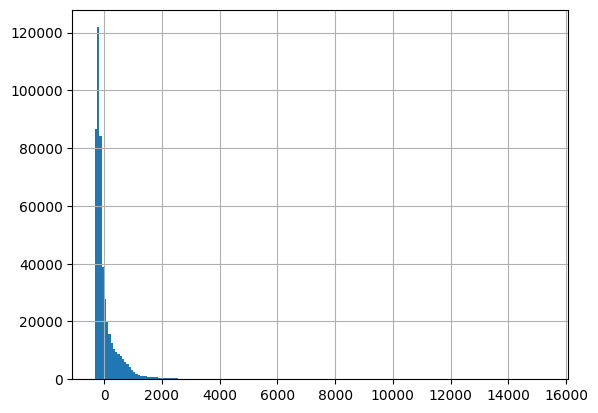

In [268]:
testDf.absErr_cons.hist(bins=200)

In [45]:
testDf.absErr_prod.hist(bins=200)

AttributeError: 'DataFrame' object has no attribute 'absErr_prod'

<Axes: >

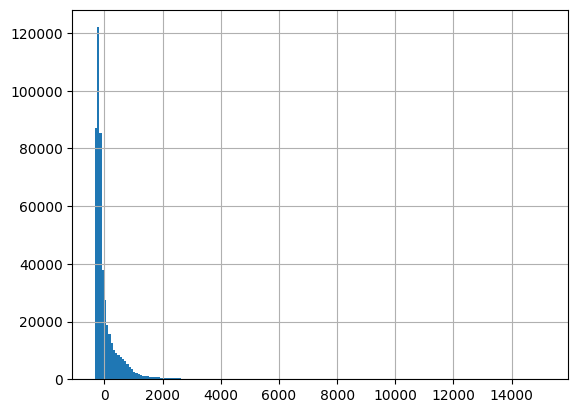

In [269]:
trainDf.absErr_cons.hist(bins=200)

In [47]:
trainDf.absErr_prod.hist(bins=200)

AttributeError: 'DataFrame' object has no attribute 'absErr_prod'

### investigate consumption
- some heavy overestimation (when no consumption but we predict one)
- some heave underestimation, when lots of consumption but no prediciton



In [441]:
print(testDf.y_cons.mean(),testDf.y_cons.std())
print(testDf.pred_cons.mean(),testDf.pred_cons.std())

print(trainDf.y_cons.mean(),trainDf.y_cons.std())
print(trainDf.pred_cons.mean(),trainDf.pred_cons.std())

448.0924781740108 1160.7522678616065
418.27048 43.226375579833984
464.8566583718962 1210.1171201557072
418.27066 43.18152618408203


<Axes: xlabel='hours_ahead'>

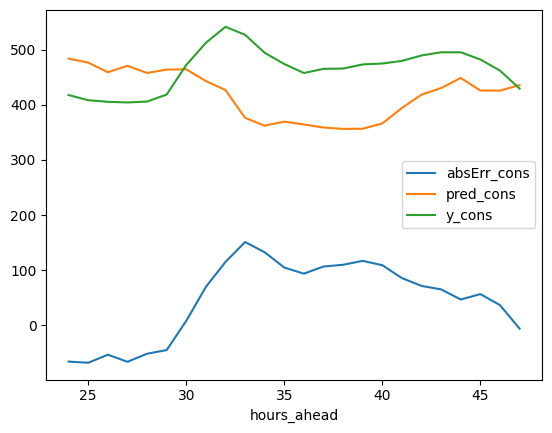

In [442]:
trainDf.groupby('hours_ahead')[['absErr_cons','pred_cons','y_cons']].mean().plot()

<Axes: xlabel='hours_ahead'>

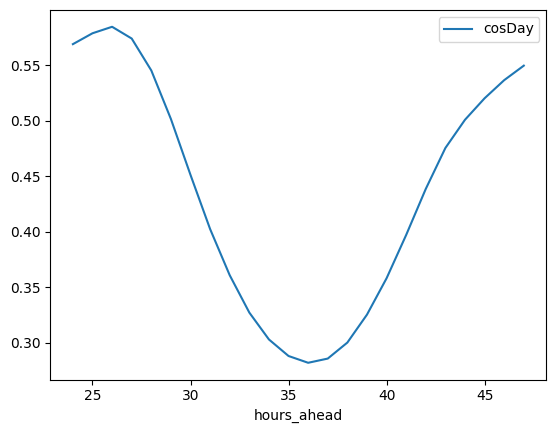

In [443]:
trainDf.groupby('hours_ahead')[['cosDay']].mean().plot()

<Axes: xlabel='yearday'>

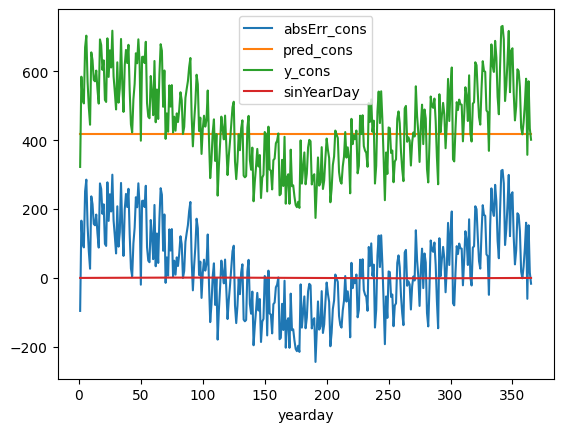

In [444]:
trainDf.groupby('yearday')[['absErr_cons','pred_cons','y_cons','sinYearDay']].mean().plot()

<Axes: xlabel='yearday'>

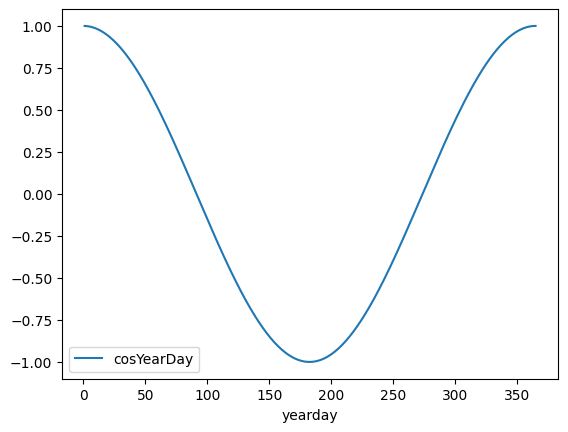

In [400]:
trainDf.groupby('yearday')[['cosYearDay']].mean().plot()

In [274]:
pd.set_option('Display.max_columns', None)
pd.set_option('Display.max_rows', None)
cond = (testDf.data_block_id == 469) & (testDf.prediction_unit_id == 5) & (testDf.county == 0)
cond = (testDf.data_block_id == 495) & (testDf.prediction_unit_id == 21) & (testDf.county == 5)
testDf.loc[cond]

#pd.set_option('Display.max_columns', 10)
#pd.set_option('Display.max_rows', 10)


,y_cons,y_prod,isTrain,data_block_id,county,is_business,product_type,prediction_unit_id,eic_count,installed_capacity,business_prodType,ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh,yearday,weekday,month,monthday,ePrices,County,hours_ahead,County,temperatureint,pred_cons,absErr_cons
527040,177.00,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,24.44,5.0,0.0,5.0,-14.458581,297.226837,-120.226837
527041,169.25,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,52.50,5.0,1.0,5.0,-14.106949,287.167328,-117.917328
527042,126.40,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,46.16,5.0,2.0,5.0,-13.669215,286.255219,-159.855219
527043,170.37,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,34.41,5.0,3.0,5.0,-13.369215,283.637512,-113.267512
527044,242.11,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,44.38,5.0,4.0,5.0,-13.231482,287.126007,-45.016007
527045,266.68,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,9.92,5.0,5.0,5.0,-13.262615,286.621735,-19.941735
527046,264.38,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,49.71,5.0,6.0,5.0,-13.562615,299.921326,-35.541326
527047,365.46,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,57.67,5.0,7.0,5.0,-13.793748,297.099091,68.360909
527048,383.20,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,75.53,5.0,8.0,5.0,-13.986799,268.754211,114.445789
527049,342.70,0.0,0.0,495.0,5.0,1.0,0.0,21.0,9.0,505.6,5.0,599.0,76.0,82.95,9.0,0.0,1.0,9.0,95.76,5.0,9.0,5.0,-14.262615,232.674133,110.025867


<Axes: xlabel='data_block_id'>

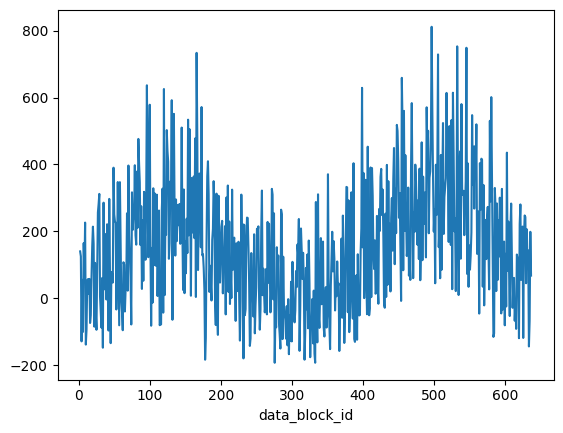

In [134]:
testDf.groupby('data_block_id')['absErr_cons'].mean().plot() 

In [217]:
testDf.loc[testDf.absErr_cons < -140].y_cons.mean()

57.601196242992785

In [220]:
testDf.loc[testDf.absErr_cons < -140].pred_cons.mean()

330.74252

In [332]:
testDf.columns
#yearday
#monthday

Index(['y_cons', 'y_prod', 'isTrain', 'data_block_id', 'county', 'is_business',
       'product_type', 'prediction_unit_id', 'eic_count', 'installed_capacity',
       'business_prodType', 'ind_customer_id', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'yearday', 'weekday', 'month', 'monthday',
       'sinYearDay', 'cosYearDay', 'ePrices', 'hours_ahead', 'temperatureint',
       'sinDay', 'cosDay', 'temperatureint', 'pred_cons', 'absErr_cons'],
      dtype='object')

array([[<Axes: title={'center': 'cons_prod_diff'}>]], dtype=object)

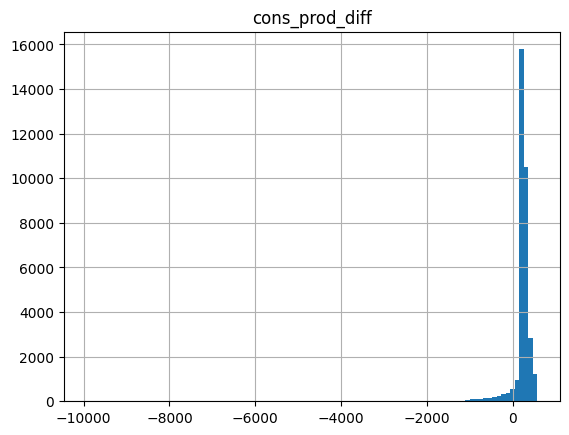

In [246]:
cond = testDf.absErr_cons > 200
cond = (testDf.absErr_cons < 50) & (testDf.absErr_cons > -50)
#cond = testDf.absErr_cons < -100

testDf.loc[cond][['cons_prod_diff']].hist(bins=100)#.sort_values(by='absErr_cons').tail(15) 
#,'pred_cons','y_cons' .groupby('yearday')

In [114]:
from datetime import datetime, timedelta

# Specify the year and the day of the year
year = 2022
day_of_year = [246.0, 276,123,3,184,307,93,154,215,34,62,337]

# Calculate the date
for day in day_of_year:
    date_from_day_of_year = datetime(year, 1, 1) + timedelta(days=day - 1)
    print(date_from_day_of_year)


2022-09-03 00:00:00
2022-10-03 00:00:00
2022-05-03 00:00:00
2022-01-03 00:00:00
2022-07-03 00:00:00
2022-11-03 00:00:00
2022-04-03 00:00:00
2022-06-03 00:00:00
2022-08-03 00:00:00
2022-02-03 00:00:00
2022-03-03 00:00:00
2022-12-03 00:00:00


In [117]:
testDf.loc[(testDf.absErr_cons < -140) & (testDf.yearday == 246)]

,y_cons,y_prod,isTrain,data_block_id,county,is_business,product_type,prediction_unit_id,eic_count,installed_capacity,...,ind_customer_id,lowest_price_per_mwh,highest_price_per_mwh,yearday,weekday,month,monthday,ePrices,pred_cons,absErr_cons
804267,68.640,0.000,0.0,2.0,14.0,0.0,3.0,54.0,105.0,1423.36,...,1072.0,45.62,46.29,246.0,4.0,9.0,3.0,92.25,216.413940,-147.773940
804270,78.256,0.563,0.0,2.0,14.0,0.0,3.0,54.0,105.0,1423.36,...,1072.0,45.62,46.29,246.0,4.0,9.0,3.0,128.94,229.251709,-150.995709
804271,82.277,11.833,0.0,2.0,14.0,0.0,3.0,54.0,105.0,1423.36,...,1072.0,45.62,46.29,246.0,4.0,9.0,3.0,150.00,225.772629,-143.495629
804272,75.056,14.559,0.0,2.0,14.0,0.0,3.0,54.0,105.0,1423.36,...,1072.0,45.62,46.29,246.0,4.0,9.0,3.0,146.38,215.182831,-140.126831
804278,21.493,552.771,0.0,2.0,14.0,0.0,3.0,54.0,105.0,1423.36,...,1072.0,45.62,46.29,246.0,4.0,9.0,3.0,97.97,165.838745,-144.345745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004589,47.403,0.000,0.0,30.0,4.0,0.0,3.0,16.0,45.0,568.30,...,1002.0,50.15,69.99,246.0,4.0,9.0,3.0,142.08,225.741013,-178.338013
1004590,43.739,0.000,0.0,30.0,4.0,0.0,3.0,16.0,45.0,568.30,...,1002.0,50.15,69.99,246.0,4.0,9.0,3.0,104.80,222.144104,-178.405104
1004591,34.488,0.000,0.0,30.0,4.0,0.0,3.0,16.0,45.0,568.30,...,1002.0,50.15,69.99,246.0,4.0,9.0,3.0,81.53,219.334274,-184.846274
1004608,82.614,138.410,0.0,12.0,8.0,1.0,3.0,33.0,17.0,751.70,...,1602.0,46.50,47.62,246.0,4.0,9.0,3.0,87.13,226.160583,-143.546583


<Axes: >

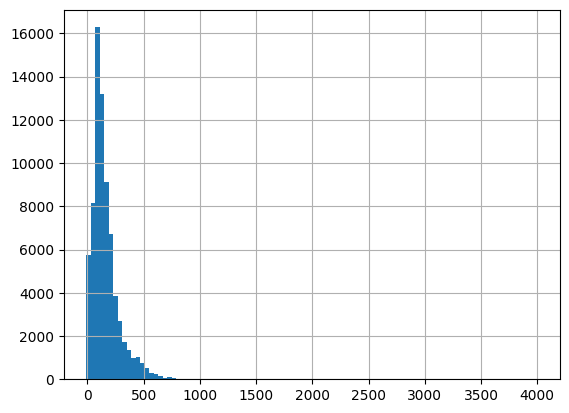

In [102]:
testDf.loc[testDf.absErr_cons < -140].ePrices.hist(bins=100)

In [221]:
print(testDf.loc[testDf.absErr_cons > 220].y_cons.mean(),
testDf.loc[testDf.absErr_cons > 220].pred_cons.mean())

1810.2856380464455 306.32648


In [160]:
pd.set_option('Display.max_rows',None)
print(testDf.loc[testDf.absErr_cons < -100].groupby(['monthday','yearday'])['absErr_cons'].count())
#day 3 is really bad
pd.set_option('Display.max_rows',10)

monthday  yearday
1.0       91.0         832
          121.0         48
          213.0         14
          274.0         24
          305.0         89
2.0       33.0           6
          61.0          26
          92.0          38
          122.0          8
          183.0         48
          214.0         48
          275.0         24
3.0       3.0        31319
          34.0       19689
          62.0       17227
          93.0       19919
          123.0      25925
          154.0      14404
          184.0      16243
          215.0      12955
          246.0      35830
          276.0      30419
          307.0      20954
          337.0      16627
4.0       63.0         918
          94.0         418
          124.0        175
          155.0        240
          247.0        504
          338.0         72
5.0       5.0           32
          36.0          72
          64.0         140
          125.0        288
          217.0        312
          248.0        264
          

<Axes: >

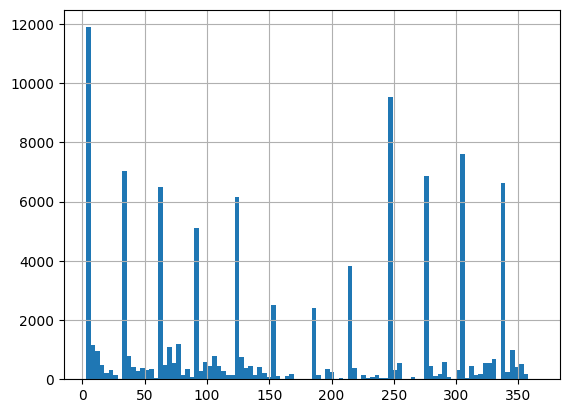

In [141]:
testDf.loc[testDf.absErr_cons > 220].yearday.hist(bins=100)

In [83]:
testDf.y_cons.mean()

448.0924781740108

<Axes: >

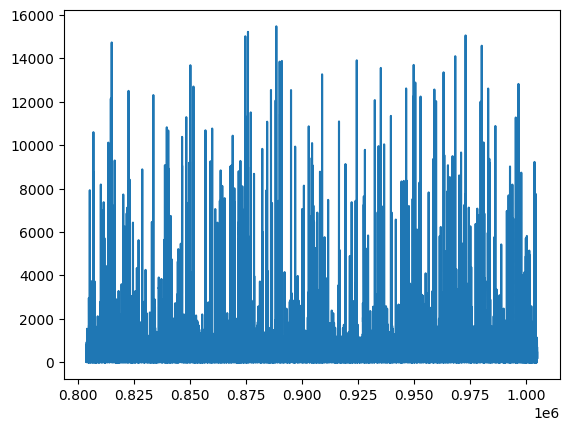

In [64]:
testDf.y_cons.plot()

In [65]:
abs(testDf.absErr_prod).mean()

AttributeError: 'DataFrame' object has no attribute 'absErr_prod'

In [66]:
abs(testDf.absErr_cons).mean()

460.76425311036706

In [ ]:
testDf.absErr_cons.mean()

In [ ]:
testDf.groupby('minDaylight')['absErr_prod'].max().plot() #hist(bins=100)

In [ ]:
testDf.loc[testDf.absErr_prod <100].data_block_id.hist(bins=20)

In [ ]:
fig = subplots.make_subplots(rows=1, cols=1,shared_xaxes=True)
fig.add_trace(go.Scatter(x = testDf['data_block_id'], y = testDf['absErr_cons'],mode ='markers', name='diff_snowfall'),row=1, col=1)
fig.show()

<Axes: >

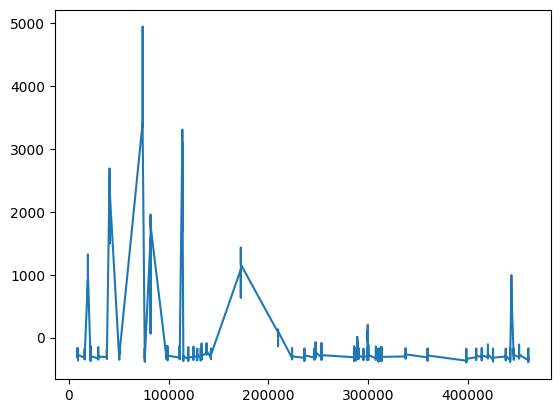

In [168]:
trainDf.loc[trainDf.monthday == 1].absErr_cons.plot()

### investigate 3rd day of month

In [178]:
pd.set_option('Display.max_rows',None)
print(appendedDf.weekday.value_counts())

pd.set_option('Display.max_rows',10)

weekday
4.0    212976
6.0    163656
0.0    148224
3.0    138360
1.0    123168
5.0    111504
2.0    106968
Name: count, dtype: int64


<Axes: >

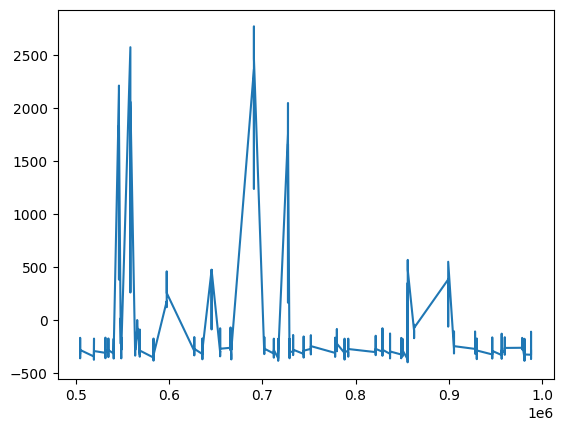

In [165]:
testDf.loc[testDf.monthday == 1].absErr_cons.plot()